# Regression task for the data sent earlier by ql2

In [1]:
# all imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from math import sqrt
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Reading data
# airfare_data = pd.read_csv("airfare_lax_2019_initial.csv", delimiter=",")
airfare_data = pd.read_csv("../Data/Airfare data with day_of_week.csv", delimiter=",")
airfare_data.rename(columns = {"EXTRACT(WEEK FROM DDATE)" : "week", "DAYOFWEEK(DDATE)" : "dayofweek" ,
                              "AVG(FARE)": "average", "MIN(FARE)": "min", "MAX(FARE)": "max", 
                               "MEDIAN(FARE)" : "median", "STDDEV(FARE)" : "stddev"} , inplace = True)
airport_distance_data = pd.read_csv("../Data/distance_between_airports.csv", delimiter=",")

In [3]:
airfare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344666 entries, 0 to 344665
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   TO_AIRPORT    344666 non-null  object 
 1   CXR           344666 non-null  object 
 2   FROM_AIRPORT  344666 non-null  object 
 3   week          344666 non-null  int64  
 4   dayofweek     344666 non-null  int64  
 5   average       344666 non-null  float64
 6   min           344666 non-null  float64
 7   max           344666 non-null  float64
 8   median        344666 non-null  float64
 9   stddev        341659 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 26.3+ MB


In [4]:
weekdays = [1,2,3,4]
airfare_data["weekend"] = np.where(airfare_data["dayofweek"].isin(weekdays) == True, 0, 1) 

In [5]:
airfare_data.head()

,TO_AIRPORT,CXR,FROM_AIRPORT,week,dayofweek,average,min,max,median,stddev,weekend
0,ADQ,AS,ANC,1,0,213.25,109.0,362.0,191.0,101.647500,1
1,ADQ,AS,ANC,1,2,300.25,170.0,462.0,313.5,109.914946,0
2,ADQ,AS,ANC,1,3,262.00,158.0,462.0,170.0,141.506184,0
3,ADQ,AS,ANC,1,4,252.00,126.0,362.0,260.0,118.215300,0
4,ADQ,AS,ANC,1,5,294.00,126.0,462.0,362.0,136.782065,1


## Merging distance

In [6]:
airport_distance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379625 entries, 0 to 379624
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   AIRPORT_FROM  379625 non-null  object
 1   AIRPORT_TO    379625 non-null  object
 2    MILES        379625 non-null  object
dtypes: object(3)
memory usage: 8.7+ MB


In [7]:
airfare_data = pd.merge(airfare_data, airport_distance_data, how = "left", left_on = ["FROM_AIRPORT", "TO_AIRPORT"]
                  , right_on = ["AIRPORT_FROM", "AIRPORT_TO"])

# Dropping unnecessary columns
airfare_data.drop(columns = ["AIRPORT_FROM", "AIRPORT_TO"], axis=1, inplace = True)

# Renaming Miles column
airfare_data.rename(columns = {" MILES " : "miles"} , inplace = True)

# Removing comma and extra space from each entry in miles
airfare_data["miles"] = airfare_data["miles"].apply(lambda x : x.replace(",", "").strip())

# Converting to numeric
airfare_data["miles"] = pd.to_numeric(airfare_data["miles"])

# Adding price/mile column
airfare_data["price_per_mile"] = airfare_data["average"] / airfare_data["miles"]

In [8]:
airfare_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357808 entries, 0 to 357807
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TO_AIRPORT      357808 non-null  object 
 1   CXR             357808 non-null  object 
 2   FROM_AIRPORT    357808 non-null  object 
 3   week            357808 non-null  int64  
 4   dayofweek       357808 non-null  int64  
 5   average         357808 non-null  float64
 6   min             357808 non-null  float64
 7   max             357808 non-null  float64
 8   median          357808 non-null  float64
 9   stddev          354712 non-null  float64
 10  weekend         357808 non-null  int64  
 11  miles           357808 non-null  int64  
 12  price_per_mile  357808 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 38.2+ MB


## Restricting to LAX

In [9]:
lax_data = airfare_data[airfare_data["TO_AIRPORT"] == "LAX"]
lax_data.head()

,TO_AIRPORT,CXR,FROM_AIRPORT,week,dayofweek,average,min,max,median,stddev,weekend,miles,price_per_mile
156132,LAX,AS,JFK,1,0,278.100000,243.0,429.0,243.0,66.108413,1,2469,0.112637
156133,LAX,AS,JFK,1,2,465.266667,392.0,697.0,472.0,72.132286,0,2469,0.188443
156134,LAX,AS,JFK,1,3,454.200000,367.0,697.0,392.0,120.372385,0,2469,0.183961
156135,LAX,AS,JFK,1,4,326.000000,209.0,429.0,319.0,73.025110,0,2469,0.132037
156136,LAX,AS,JFK,1,5,282.600000,209.0,392.0,284.0,49.279701,1,2469,0.114459


## How we interpret features?

TO_AIRPORT -> DROP

CXR -> convert to numerical (1 hot encoding for now)

FROM_AIPORT -> convert to numerical (1 hot encoding for now)

week -> convert to numerical (1 hot encoding for now)

dayofweek -> convert to numerical (1 hot encoding for now)

average -> Drop, try for regression later

min -> Drop

max -> Drop

median -> Drop

stddev -> Drop

weekend -> convert to numerical (1 hot encoding for now)

price_per_mile -> Target y variable

count    22611.000000
mean         0.403434
std          0.531082
min          0.033032
25%          0.152563
50%          0.231842
75%          0.379268
max          4.043135
Name: price_per_mile, dtype: float64

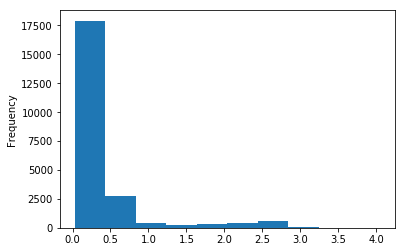

In [10]:
# lax_data.isnull().sum()
lax_data["price_per_mile"].plot(kind="hist")
lax_data["price_per_mile"].describe()

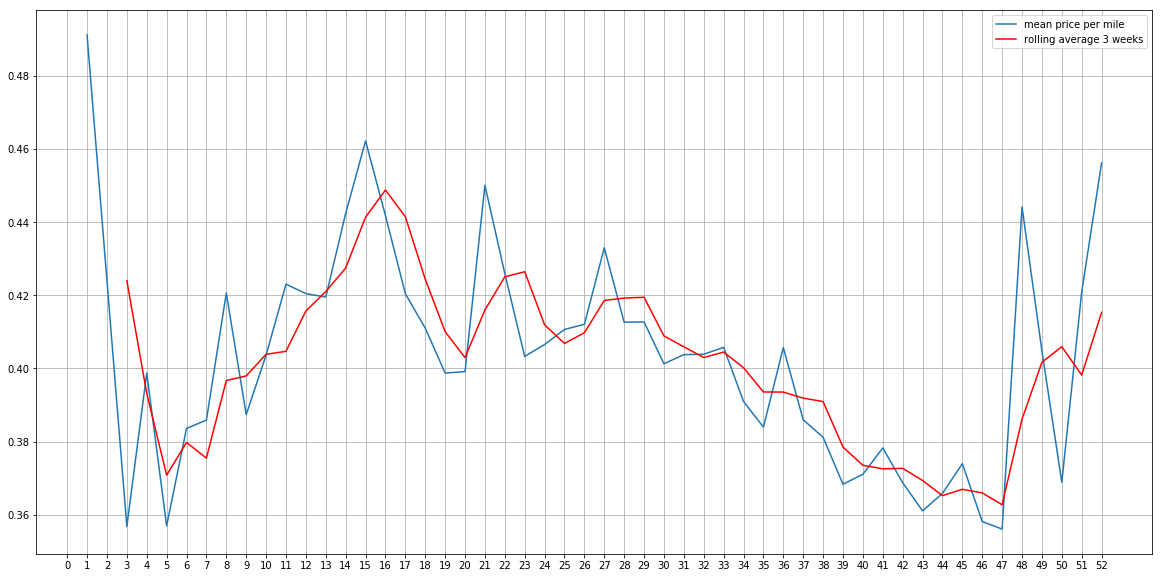

In [11]:
lax_data.head()
plt.figure(figsize=(20,10))
plt.plot(lax_data.groupby(by = ["week"])["price_per_mile"].mean())
plt.plot(lax_data.groupby(by = ["week"])["price_per_mile"].mean().rolling(window=3).mean(), 'k-', color="red")
plt.xticks(range(0,53))
plt.grid()
plt.legend(["mean price per mile", "rolling average 3 weeks"])
plt.show()

In [12]:
# Preprocessing
airfare_data_regression = lax_data.copy()
drop_columns = ["TO_AIRPORT", "average", "min", "max", "median", "stddev", "miles", "dayofweek"]
airfare_data_regression.drop(columns = drop_columns , axis=1, inplace = True)
one_hot_encoding_columns = ["CXR", "FROM_AIRPORT", "week", "weekend"]
airfare_data_regression = pd.get_dummies(airfare_data_regression,columns=one_hot_encoding_columns, 
                                         prefix = one_hot_encoding_columns, drop_first=True)
airfare_data_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22611 entries, 156132 to 178742
Data columns (total 91 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_per_mile    22611 non-null  float64
 1   CXR_B6            22611 non-null  uint8  
 2   CXR_DL            22611 non-null  uint8  
 3   CXR_HA            22611 non-null  uint8  
 4   CXR_NK            22611 non-null  uint8  
 5   CXR_UA            22611 non-null  uint8  
 6   FROM_AIRPORT_BOS  22611 non-null  uint8  
 7   FROM_AIRPORT_CUN  22611 non-null  uint8  
 8   FROM_AIRPORT_DCA  22611 non-null  uint8  
 9   FROM_AIRPORT_DEN  22611 non-null  uint8  
 10  FROM_AIRPORT_DFW  22611 non-null  uint8  
 11  FROM_AIRPORT_DTW  22611 non-null  uint8  
 12  FROM_AIRPORT_EUG  22611 non-null  uint8  
 13  FROM_AIRPORT_EWR  22611 non-null  uint8  
 14  FROM_AIRPORT_FAT  22611 non-null  uint8  
 15  FROM_AIRPORT_FLL  22611 non-null  uint8  
 16  FROM_AIRPORT_HNL  22611 non-null  

In [13]:
# Data view
airfare_data_regression.head()

,price_per_mile,CXR_B6,CXR_DL,CXR_HA,CXR_NK,CXR_UA,FROM_AIRPORT_BOS,FROM_AIRPORT_CUN,FROM_AIRPORT_DCA,FROM_AIRPORT_DEN,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,weekend_1
156132,0.112637,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
156133,0.188443,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156134,0.183961,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156135,0.132037,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156136,0.114459,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
regression_columns = [column for column in airfare_data_regression.columns.tolist() if column!="price_per_mile"]
X = airfare_data_regression[regression_columns]
y = airfare_data_regression["price_per_mile"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [82]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Train RMSE error", sqrt(mean_squared_error(y_train, reg.predict(X_train))))
print("Test RMSE error", sqrt(mean_squared_error(y_test, reg.predict(X_test))))
print("Coefficients")
for x, y in zip(X_train.columns.tolist(), reg.coef_):
    print(x,round(y,2))
from sklearn.metrics import r2_score
print(r2_score(y_test, reg.predict(X_test)))

Train RMSE error 0.15054358851763047
Test RMSE error 0.15062087540412233
Coefficients
CXR_B6 0.04
CXR_DL 0.12
CXR_HA 0.17
CXR_NK -0.1
CXR_UA 0.23
FROM_AIRPORT_BOS 0.05
FROM_AIRPORT_CUN 0.07
FROM_AIRPORT_DCA 0.17
FROM_AIRPORT_DEN 0.15
FROM_AIRPORT_DFW 0.1
FROM_AIRPORT_DTW 0.2
FROM_AIRPORT_EUG 0.22
FROM_AIRPORT_EWR 0.07
FROM_AIRPORT_FAT 1.77
FROM_AIRPORT_FLL 0.16
FROM_AIRPORT_HNL 0.04
FROM_AIRPORT_IAD 0.05
FROM_AIRPORT_IAH 0.22
FROM_AIRPORT_JFK 0.16
FROM_AIRPORT_KOA 0.04
FROM_AIRPORT_LAS 0.52
FROM_AIRPORT_LHR 0.79
FROM_AIRPORT_LIH 0.02
FROM_AIRPORT_MCI 0.2
FROM_AIRPORT_MCO 0.0
FROM_AIRPORT_MEX 0.29
FROM_AIRPORT_MSP 0.19
FROM_AIRPORT_MSY 0.21
FROM_AIRPORT_OAK 0.35
FROM_AIRPORT_OGG 0.08
FROM_AIRPORT_ORD 0.1
FROM_AIRPORT_PDX 0.09
FROM_AIRPORT_PHL 0.18
FROM_AIRPORT_RNO 0.31
FROM_AIRPORT_SAN 2.06
FROM_AIRPORT_SEA 0.1
FROM_AIRPORT_SFO 0.36
FROM_AIRPORT_SLC 0.24
week_2 -0.06
week_3 -0.14
week_4 -0.1
week_5 -0.13
week_6 -0.11
week_7 -0.12
week_8 -0.09
week_9 -0.12
week_10 -0.1
week_11 -0.08
week

In [16]:
clf = linear_model.Lasso()
clf.fit(X_train, y_train)
print("Train RMSE error", sqrt(mean_squared_error(y_train, clf.predict(X_train))))
print("Test RMSE error", sqrt(mean_squared_error(y_test, clf.predict(X_test))))
print("Coefficients")
for x, y in zip(X_train.columns.tolist(), clf.coef_):
    print(x,round(y,2))

Train RMSE error 0.5324336744754259
Test RMSE error 0.528291349788383
Coefficients
CXR_B6 -0.0
CXR_DL 0.0
CXR_HA -0.0
CXR_NK -0.0
CXR_UA 0.0
FROM_AIRPORT_BOS -0.0
FROM_AIRPORT_CUN -0.0
FROM_AIRPORT_DCA -0.0
FROM_AIRPORT_DEN -0.0
FROM_AIRPORT_DFW -0.0
FROM_AIRPORT_DTW -0.0
FROM_AIRPORT_EUG 0.0
FROM_AIRPORT_EWR -0.0
FROM_AIRPORT_FAT 0.0
FROM_AIRPORT_FLL -0.0
FROM_AIRPORT_HNL -0.0
FROM_AIRPORT_IAD -0.0
FROM_AIRPORT_IAH -0.0
FROM_AIRPORT_JFK -0.0
FROM_AIRPORT_KOA -0.0
FROM_AIRPORT_LAS 0.0
FROM_AIRPORT_LHR 0.0
FROM_AIRPORT_LIH -0.0
FROM_AIRPORT_MCI -0.0
FROM_AIRPORT_MCO -0.0
FROM_AIRPORT_MEX 0.0
FROM_AIRPORT_MSP -0.0
FROM_AIRPORT_MSY -0.0
FROM_AIRPORT_OAK -0.0
FROM_AIRPORT_OGG -0.0
FROM_AIRPORT_ORD -0.0
FROM_AIRPORT_PDX -0.0
FROM_AIRPORT_PHL -0.0
FROM_AIRPORT_RNO 0.0
FROM_AIRPORT_SAN 0.0
FROM_AIRPORT_SEA -0.0
FROM_AIRPORT_SFO 0.0
FROM_AIRPORT_SLC 0.0
week_2 0.0
week_3 -0.0
week_4 0.0
week_5 -0.0
week_6 -0.0
week_7 -0.0
week_8 0.0
week_9 -0.0
week_10 0.0
week_11 0.0
week_12 -0.0
week_13 -0.0

## Trying Random forest regressor

In [74]:
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)
print("Train RMSE error", sqrt(mean_squared_error(y_train, regr.predict(X_train))))
print("Test RMSE error", sqrt(mean_squared_error(y_test, regr.predict(X_test))))

Train RMSE error 0.14439980378990044
Test RMSE error 0.14290854162293581


In [75]:
print("Coefficients")
for x, y in zip(X_train.columns.tolist(), regr.feature_importances_):
    print(x,round(y,2))

Coefficients
CXR_B6 0.0
CXR_DL 0.02
CXR_HA 0.0
CXR_NK 0.03
CXR_UA 0.01
FROM_AIRPORT_BOS 0.0
FROM_AIRPORT_CUN 0.0
FROM_AIRPORT_DCA 0.0
FROM_AIRPORT_DEN 0.0
FROM_AIRPORT_DFW 0.0
FROM_AIRPORT_DTW 0.0
FROM_AIRPORT_EUG 0.0
FROM_AIRPORT_EWR 0.0
FROM_AIRPORT_FAT 0.0
FROM_AIRPORT_FLL 0.0
FROM_AIRPORT_HNL 0.0
FROM_AIRPORT_IAD 0.0
FROM_AIRPORT_IAH 0.0
FROM_AIRPORT_JFK 0.0
FROM_AIRPORT_KOA 0.0
FROM_AIRPORT_LAS 0.05
FROM_AIRPORT_LHR 0.01
FROM_AIRPORT_LIH 0.0
FROM_AIRPORT_MCI 0.0
FROM_AIRPORT_MCO 0.0
FROM_AIRPORT_MEX 0.0
FROM_AIRPORT_MSP 0.0
FROM_AIRPORT_MSY 0.0
FROM_AIRPORT_OAK 0.0
FROM_AIRPORT_OGG 0.0
FROM_AIRPORT_ORD 0.0
FROM_AIRPORT_PDX 0.0
FROM_AIRPORT_PHL 0.0
FROM_AIRPORT_RNO 0.0
FROM_AIRPORT_SAN 0.88
FROM_AIRPORT_SEA 0.0
FROM_AIRPORT_SFO 0.0
FROM_AIRPORT_SLC 0.0
week_2 0.0
week_3 0.0
week_4 0.0
week_5 0.0
week_6 0.0
week_7 0.0
week_8 0.0
week_9 0.0
week_10 0.0
week_11 0.0
week_12 0.0
week_13 0.0
week_14 0.0
week_15 0.0
week_16 0.0
week_17 0.0
week_18 0.0
week_19 0.0
week_20 0.0
week_21 0.0
w

In [76]:
estimator = regr.estimators_[10]
from sklearn.tree import export_graphviz
# # Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns.tolist(),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [32]:
#SAN -> Sandiego has 0.92
lax_data.groupby("FROM_AIRPORT").mean()["price_per_mile"]

FROM_AIRPORT
AUS    0.171699
BOS    0.178588
CUN    0.189091
DCA    0.289034
DEN    0.273117
DFW    0.142947
DTW    0.098803
EUG    0.450633
EWR    0.295719
FAT    1.933014
FLL    0.132642
HNL    0.213456
IAD    0.280196
IAH    0.119022
JFK    0.235742
KOA    0.219048
LAS    0.611213
LHR    1.015211
LIH    0.215559
MCI    0.106782
MCO    0.179122
MEX    0.402512
MSP    0.200303
MSY    0.114005
OAK    0.246334
OGG    0.240269
ORD    0.159328
PDX    0.195959
PHL    0.079565
RNO    0.539717
SAN    2.222332
SEA    0.269316
SFO    0.525861
SLC    0.406727
Name: price_per_mile, dtype: float64

San Diego has the highest price per mile. Almost 2 times the max otherwise.

The mile distance between the airports is 109. Average price is 242. This the closest airport to the LAX airport based on analysis.

In [52]:
# lax_data[lax_data["FROM_AIRPORT"] == "SAN"]["average"].describe()
lax_data[lax_data["miles"] <= 109]["FROM_AIRPORT"].value_counts()

SAN    1456
Name: FROM_AIRPORT, dtype: int64